# Combining Image Classification and NLP Models Together

## Import Libraries

In [1]:
# change the python's path to the parent directory
import sys
sys.path.append("../")

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
import numpy as np

from models.popular_models import PopularModels
from models.lstm import LSTM
from torchvision import transforms
from tqdm import tqdm
from data.dataset import MultiLabelDataset
from tools.tools import get_data, load_data, tokenize, remove_class, count_class, calculate_pos_weights
from torch.utils.data import DataLoader
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

## Remove unused memory in GPU

In [3]:
gc.collect()
torch.cuda.empty_cache()

## Load the Data

In [4]:
# import data
train_data = get_data("../dataset/train.csv")
test_data = get_data("../dataset/test.csv")

# perform text cleaning and get the pandas' dataframe
train_data = load_data(train_data)
test_data = load_data(test_data, has_label=False)

# remove an imbalanced class
train_data = remove_class(train_data, class_no=1)

# join the data together
for_nlp_data = pd.concat((train_data['caption'], test_data['caption']), ignore_index=True)

In [5]:
print(f"Number of training instances: {train_data.shape[0]}")
print(f"Number of testing instances:  {test_data.shape[0]}")

Number of training instances: 15925
Number of testing instances:  10000


## Preprocessing for Images and Caption

In [6]:
# define the image transformation: currently following resnet18
transform = transforms.Compose([
	transforms.Resize((232, 232)),
	transforms.CenterCrop(224),
	transforms.ToTensor(), # converts images to [0, 1]
	transforms.Normalize(
		mean=[0.485, 0.456, 0.406],
		std=[0.229, 0.224, 0.225],
	)
])

# tokenize the data
final_list, vocab = tokenize(for_nlp_data)
X_train_vec = final_list[:train_data.shape[0], :]
X_test_vec = final_list[train_data.shape[0]:, :]

Max Sentence Length: 28


## Create Dataset and DataLoader

In [7]:
# initialize the dataset
train_dataset = MultiLabelDataset(
	csv_file=train_data,
	root_dir='../dataset/data/',
	vectorizer=None,
	transform=transform,
	use_caption_vec=True,
	caption_vec=X_train_vec,
	is_test=False,
)
test_dataset = MultiLabelDataset(
	csv_file=test_data,
	root_dir='../dataset/data/',
	vectorizer=None,
	transform=transform,
	use_caption_vec=True,
	caption_vec=X_test_vec,
	is_test=True,
)

BATCH_SIZE=16

# load the dataset into batches 
train_dataloader = DataLoader(
	dataset=train_dataset,
	batch_size=BATCH_SIZE,
	shuffle=True,
)
test_dataloader = DataLoader(
	dataset=test_dataset,
	batch_size=BATCH_SIZE,
	shuffle=False,
)

## Create the Combined Model

In [8]:
class CombinedModel(nn.Module):

	def __init__(
			self, 
			choice: str, 
			pretrained: bool, 
			freeze: bool, 
			cnn_n_out: int,
			no_layers: int,
			vocab_size: int,
			embedding_dim: int,
			lstm_hidden_dim: int,
			lstm_n_out: int
		) -> None:
		super(CombinedModel, self).__init__()

		# get the CNN model for image classification
		self.cnn_model = PopularModels(
			choice=choice,
			pretrained=pretrained,
			freeze=freeze,
			n_out=cnn_n_out,
		).get_model()

		# get the LSTM model for text classification
		self.lstm_model = LSTM(
			no_layers=no_layers,
			vocab_size=vocab_size + 1,
			embedding_dim=embedding_dim,
			hidden_dim=lstm_hidden_dim,
			output_dim=lstm_n_out,
		)
		
		# create the final fully connected layer
		self.last_layer = nn.Linear(cnn_n_out + lstm_n_out, 19)

	def forward(self, x, y, hidden):
		x = self.cnn_model(x)
		y, hidden = self.lstm_model(y, hidden)
		
		output = torch.cat((x, y), dim=1)
		output = self.last_layer(output)

		return output, hidden

## Define the model

In [9]:
class_counts = list(count_class(train_data).values())
pos_weights = calculate_pos_weights(class_counts, train_data)
if torch.cuda.is_available():
	pos_weights = pos_weights.to('cuda')

In [10]:
EPOCHS = 100
THRESHOLD = 0.5
N_CLASSES = 19

model = CombinedModel(
	choice="regnet_x_1_6gf",
	pretrained=True, 		# if pretrained is False, then freeze should also be False
	freeze=True,
	cnn_n_out=256,
	no_layers=2,
	vocab_size=len(vocab), 	# already added by 1
	embedding_dim=64,
	lstm_hidden_dim=256,
	lstm_n_out=128,
)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
optimizer = torch.optim.Adam(
	params=model.parameters(),
	lr=0.001,
)

# utilise GPU
if torch.cuda.is_available():
	print('using GPU')
	model = model.to('cuda')

using GPU


## Train the model

In [11]:
clip = 5 # for exploding gradient problem
train_losses = []
train_accs = []
sk_train_accs = []
for epoch in range(EPOCHS):

	# initialize the hidden state
	hidden = model.lstm_model.init_hidden(batch_size=BATCH_SIZE)

	start = 0 # index
	y_true = np.zeros((train_data.shape[0], N_CLASSES))
	y_preds = np.zeros((train_data.shape[0], N_CLASSES))
	n_total = 0
	n_correct = 0
	train_loss = 0.
	model.train()
	for image_names, images, captions, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1} Training: "):

		if torch.cuda.is_available():
			images = images.to('cuda')
			captions = captions.to('cuda')
			labels = labels.to('cuda')
		
		# creating new variables for the hidden state, otherwise
		# we'd backprop through the entire training history
		hidden = tuple([each.data for each in hidden])

		optimizer.zero_grad()
		y_pred, hidden = model(images, captions, hidden)

		# backward
		loss = loss_fn(y_pred, labels)
		loss.backward()

		# clip_grad_norm helps prevent the exploding gradient problem in RNNs/LSTMs
		nn.utils.clip_grad_norm_(model.parameters(), clip)

		# update
		optimizer.step()

		# compare
		predicted = (F.sigmoid(y_pred) > THRESHOLD).int()

		n = images.shape[0]
		y_true[start:start+n] = labels.cpu().numpy()
		y_preds[start:start+n] = predicted.cpu().numpy()
		start = start + n

		train_loss += loss.item()
		n_correct += torch.all(torch.eq(predicted, labels), dim=1).sum()
		n_total += labels.shape[0]

	train_losses.append(train_loss / len(train_dataloader))
	train_accs.append(n_correct / n_total)
	sk_train_accs.append(accuracy_score(y_true, y_preds))

	print("Epoch {:d}, Train Loss: {:.9f}, Train Accuracy: {:.7f}%".format(epoch+1, 
																		train_losses[-1], 
																		accuracy_score(y_true, y_preds)*100))

Epoch 1 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 1 Training: 100%|██████████| 996/996 [01:08<00:00, 14.49it/s]


Epoch 1, Train Loss: 0.647909418, Train Accuracy: 9.9780220%


Epoch 2 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 2 Training: 100%|██████████| 996/996 [01:06<00:00, 14.88it/s]


Epoch 2, Train Loss: 0.520252822, Train Accuracy: 17.9654631%


Epoch 3 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 3 Training: 100%|██████████| 996/996 [01:06<00:00, 14.92it/s]


Epoch 3, Train Loss: 0.465429950, Train Accuracy: 20.4583987%


Epoch 4 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 4 Training: 100%|██████████| 996/996 [01:06<00:00, 14.91it/s]


Epoch 4, Train Loss: 0.425857148, Train Accuracy: 22.7127159%


Epoch 5 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 5 Training: 100%|██████████| 996/996 [01:06<00:00, 14.94it/s]


Epoch 5, Train Loss: 0.383627886, Train Accuracy: 26.1224490%


Epoch 6 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 6 Training: 100%|██████████| 996/996 [01:06<00:00, 14.99it/s]


Epoch 6, Train Loss: 0.344043583, Train Accuracy: 28.2260597%


Epoch 7 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 7 Training: 100%|██████████| 996/996 [01:07<00:00, 14.85it/s]


Epoch 7, Train Loss: 0.305229400, Train Accuracy: 31.2150706%


Epoch 8 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 8 Training: 100%|██████████| 996/996 [01:06<00:00, 15.00it/s]


Epoch 8, Train Loss: 0.267000735, Train Accuracy: 34.1664050%


Epoch 9 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 9 Training: 100%|██████████| 996/996 [01:06<00:00, 14.98it/s]


Epoch 9, Train Loss: 0.237820847, Train Accuracy: 37.7896389%


Epoch 10 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 10 Training: 100%|██████████| 996/996 [01:06<00:00, 15.02it/s]


Epoch 10, Train Loss: 0.207856958, Train Accuracy: 40.4709576%


Epoch 11 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 11 Training: 100%|██████████| 996/996 [01:06<00:00, 15.05it/s]


Epoch 11, Train Loss: 0.179288796, Train Accuracy: 44.3453689%


Epoch 12 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 12 Training: 100%|██████████| 996/996 [01:06<00:00, 15.05it/s]


Epoch 12, Train Loss: 0.158770172, Train Accuracy: 47.7613815%


Epoch 13 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 13 Training: 100%|██████████| 996/996 [01:06<00:00, 14.87it/s]


Epoch 13, Train Loss: 0.138328280, Train Accuracy: 51.4348509%


Epoch 14 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 14 Training: 100%|██████████| 996/996 [01:06<00:00, 15.05it/s]


Epoch 14, Train Loss: 0.119837140, Train Accuracy: 55.0392465%


Epoch 15 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 15 Training: 100%|██████████| 996/996 [01:06<00:00, 15.05it/s]


Epoch 15, Train Loss: 0.110178644, Train Accuracy: 57.4882261%


Epoch 16 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 16 Training: 100%|██████████| 996/996 [01:06<00:00, 14.89it/s]


Epoch 16, Train Loss: 0.098362895, Train Accuracy: 60.4395604%


Epoch 17 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 17 Training: 100%|██████████| 996/996 [01:05<00:00, 15.09it/s]


Epoch 17, Train Loss: 0.088150339, Train Accuracy: 63.1522763%


Epoch 18 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 18 Training: 100%|██████████| 996/996 [01:06<00:00, 15.01it/s]


Epoch 18, Train Loss: 0.080389415, Train Accuracy: 65.3375196%


Epoch 19 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 19 Training: 100%|██████████| 996/996 [01:06<00:00, 15.04it/s]


Epoch 19, Train Loss: 0.068506029, Train Accuracy: 69.6954474%


Epoch 20 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 20 Training: 100%|██████████| 996/996 [01:06<00:00, 15.06it/s]


Epoch 20, Train Loss: 0.063101016, Train Accuracy: 71.2778650%


Epoch 21 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 21 Training: 100%|██████████| 996/996 [01:06<00:00, 15.00it/s]


Epoch 21, Train Loss: 0.059835904, Train Accuracy: 72.9356358%


Epoch 22 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 22 Training: 100%|██████████| 996/996 [01:05<00:00, 15.12it/s]


Epoch 22, Train Loss: 0.060333657, Train Accuracy: 72.7535322%


Epoch 23 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 23 Training: 100%|██████████| 996/996 [01:06<00:00, 14.98it/s]


Epoch 23, Train Loss: 0.047805140, Train Accuracy: 77.6577708%


Epoch 24 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 24 Training: 100%|██████████| 996/996 [01:06<00:00, 15.08it/s]


Epoch 24, Train Loss: 0.048732869, Train Accuracy: 78.7880691%


Epoch 25 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 25 Training: 100%|██████████| 996/996 [01:05<00:00, 15.14it/s]


Epoch 25, Train Loss: 0.039667131, Train Accuracy: 81.1616954%


Epoch 26 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 26 Training: 100%|██████████| 996/996 [01:06<00:00, 15.04it/s]


Epoch 26, Train Loss: 0.040922577, Train Accuracy: 82.1287284%


Epoch 27 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 27 Training: 100%|██████████| 996/996 [01:06<00:00, 15.04it/s]


Epoch 27, Train Loss: 0.041142050, Train Accuracy: 82.0470958%


Epoch 28 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 28 Training: 100%|██████████| 996/996 [01:05<00:00, 15.12it/s]


Epoch 28, Train Loss: 0.043299151, Train Accuracy: 81.8712716%


Epoch 29 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 29 Training: 100%|██████████| 996/996 [01:05<00:00, 15.09it/s]


Epoch 29, Train Loss: 0.031139090, Train Accuracy: 85.9780220%


Epoch 30 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 30 Training: 100%|██████████| 996/996 [01:06<00:00, 15.04it/s]


Epoch 30, Train Loss: 0.025291727, Train Accuracy: 88.4772370%


Epoch 31 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 31 Training: 100%|██████████| 996/996 [01:06<00:00, 14.98it/s]


Epoch 31, Train Loss: 0.021771561, Train Accuracy: 90.1852433%


Epoch 32 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 32 Training: 100%|██████████| 996/996 [01:06<00:00, 15.03it/s]


Epoch 32, Train Loss: 0.026205676, Train Accuracy: 88.8226060%


Epoch 33 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 33 Training: 100%|██████████| 996/996 [01:06<00:00, 15.04it/s]


Epoch 33, Train Loss: 0.038329899, Train Accuracy: 84.3830455%


Epoch 34 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 34 Training: 100%|██████████| 996/996 [01:06<00:00, 15.04it/s]


Epoch 34, Train Loss: 0.029466794, Train Accuracy: 88.6781790%


Epoch 35 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 35 Training: 100%|██████████| 996/996 [01:05<00:00, 15.10it/s]


Epoch 35, Train Loss: 0.023206582, Train Accuracy: 90.5996860%


Epoch 36 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 36 Training: 100%|██████████| 996/996 [01:05<00:00, 15.11it/s]


Epoch 36, Train Loss: 0.018250547, Train Accuracy: 92.3579278%


Epoch 37 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 37 Training: 100%|██████████| 996/996 [01:05<00:00, 15.14it/s]


Epoch 37, Train Loss: 0.014464354, Train Accuracy: 94.3045526%


Epoch 38 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 38 Training: 100%|██████████| 996/996 [01:06<00:00, 15.09it/s]


Epoch 38, Train Loss: 0.027234866, Train Accuracy: 89.7708006%


Epoch 39 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 39 Training: 100%|██████████| 996/996 [01:05<00:00, 15.12it/s]


Epoch 39, Train Loss: 0.035901337, Train Accuracy: 86.0722135%


Epoch 40 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 40 Training: 100%|██████████| 996/996 [01:06<00:00, 15.05it/s]


Epoch 40, Train Loss: 0.022657891, Train Accuracy: 90.8257457%


Epoch 41 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 41 Training: 100%|██████████| 996/996 [01:06<00:00, 14.99it/s]


Epoch 41, Train Loss: 0.015029681, Train Accuracy: 94.1098901%


Epoch 42 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 42 Training: 100%|██████████| 996/996 [01:06<00:00, 15.04it/s]


Epoch 42, Train Loss: 0.014175323, Train Accuracy: 94.4364207%


Epoch 43 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 43 Training: 100%|██████████| 996/996 [01:06<00:00, 15.01it/s]


Epoch 43, Train Loss: 0.017353708, Train Accuracy: 93.4191523%


Epoch 44 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 44 Training: 100%|██████████| 996/996 [01:05<00:00, 15.11it/s]


Epoch 44, Train Loss: 0.019780504, Train Accuracy: 92.0565149%


Epoch 45 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 45 Training: 100%|██████████| 996/996 [01:06<00:00, 15.04it/s]


Epoch 45, Train Loss: 0.020747522, Train Accuracy: 91.4411303%


Epoch 46 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 46 Training: 100%|██████████| 996/996 [01:06<00:00, 15.01it/s]


Epoch 46, Train Loss: 0.021428831, Train Accuracy: 91.6860283%


Epoch 47 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 47 Training: 100%|██████████| 996/996 [01:06<00:00, 15.09it/s]


Epoch 47, Train Loss: 0.018029097, Train Accuracy: 92.9544741%


Epoch 48 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 48 Training: 100%|██████████| 996/996 [01:06<00:00, 15.07it/s]


Epoch 48, Train Loss: 0.017418641, Train Accuracy: 93.1554160%


Epoch 49 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 49 Training: 100%|██████████| 996/996 [01:06<00:00, 15.08it/s]


Epoch 49, Train Loss: 0.016031027, Train Accuracy: 93.9152276%


Epoch 50 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 50 Training: 100%|██████████| 996/996 [01:05<00:00, 15.11it/s]


Epoch 50, Train Loss: 0.017912753, Train Accuracy: 93.1742543%


Epoch 51 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 51 Training: 100%|██████████| 996/996 [01:06<00:00, 15.03it/s]


Epoch 51, Train Loss: 0.022192283, Train Accuracy: 91.3783359%


Epoch 52 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 52 Training: 100%|██████████| 996/996 [01:05<00:00, 15.12it/s]


Epoch 52, Train Loss: 0.016834645, Train Accuracy: 93.5321821%


Epoch 53 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 53 Training: 100%|██████████| 996/996 [01:06<00:00, 14.91it/s]


Epoch 53, Train Loss: 0.014871388, Train Accuracy: 94.0219780%


Epoch 54 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 54 Training: 100%|██████████| 996/996 [01:06<00:00, 15.03it/s]


Epoch 54, Train Loss: 0.012588111, Train Accuracy: 94.9324961%


Epoch 55 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 55 Training: 100%|██████████| 996/996 [01:05<00:00, 15.10it/s]


Epoch 55, Train Loss: 0.018961132, Train Accuracy: 93.2621664%


Epoch 56 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 56 Training: 100%|██████████| 996/996 [01:06<00:00, 15.03it/s]


Epoch 56, Train Loss: 0.024998171, Train Accuracy: 90.8006279%


Epoch 57 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 57 Training: 100%|██████████| 996/996 [01:05<00:00, 15.13it/s]


Epoch 57, Train Loss: 0.018209660, Train Accuracy: 92.9921507%


Epoch 58 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 58 Training: 100%|██████████| 996/996 [01:06<00:00, 14.92it/s]


Epoch 58, Train Loss: 0.015265545, Train Accuracy: 93.8335950%


Epoch 59 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 59 Training: 100%|██████████| 996/996 [01:06<00:00, 15.02it/s]


Epoch 59, Train Loss: 0.013630140, Train Accuracy: 94.8006279%


Epoch 60 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 60 Training: 100%|██████████| 996/996 [01:06<00:00, 15.09it/s]


Epoch 60, Train Loss: 0.011095472, Train Accuracy: 95.6609105%


Epoch 61 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 61 Training: 100%|██████████| 996/996 [01:06<00:00, 14.92it/s]


Epoch 61, Train Loss: 0.016372602, Train Accuracy: 94.2919937%


Epoch 62 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 62 Training: 100%|██████████| 996/996 [01:05<00:00, 15.15it/s]


Epoch 62, Train Loss: 0.022766311, Train Accuracy: 91.9120879%


Epoch 63 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 63 Training: 100%|██████████| 996/996 [01:31<00:00, 10.89it/s]


Epoch 63, Train Loss: 0.022497955, Train Accuracy: 91.5792779%


Epoch 64 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 64 Training: 100%|██████████| 996/996 [01:06<00:00, 14.92it/s]


Epoch 64, Train Loss: 0.012656755, Train Accuracy: 94.7817896%


Epoch 65 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 65 Training: 100%|██████████| 996/996 [01:06<00:00, 15.00it/s]


Epoch 65, Train Loss: 0.011120466, Train Accuracy: 95.8116170%


Epoch 66 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 66 Training: 100%|██████████| 996/996 [01:06<00:00, 15.01it/s]


Epoch 66, Train Loss: 0.016781778, Train Accuracy: 93.6326531%


Epoch 67 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 67 Training: 100%|██████████| 996/996 [01:06<00:00, 15.06it/s]


Epoch 67, Train Loss: 0.018560870, Train Accuracy: 92.8916797%


Epoch 68 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 68 Training: 100%|██████████| 996/996 [01:06<00:00, 15.01it/s]


Epoch 68, Train Loss: 0.015824493, Train Accuracy: 94.0596546%


Epoch 69 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 69 Training: 100%|██████████| 996/996 [01:06<00:00, 15.01it/s]


Epoch 69, Train Loss: 0.017472119, Train Accuracy: 93.1993721%


Epoch 70 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 70 Training: 100%|██████████| 996/996 [01:05<00:00, 15.12it/s]


Epoch 70, Train Loss: 0.015653814, Train Accuracy: 94.1978022%


Epoch 71 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 71 Training: 100%|██████████| 996/996 [01:06<00:00, 15.03it/s]


Epoch 71, Train Loss: 0.018290856, Train Accuracy: 93.0423862%


Epoch 72 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 72 Training: 100%|██████████| 996/996 [01:06<00:00, 15.05it/s]


Epoch 72, Train Loss: 0.015989109, Train Accuracy: 93.6828885%


Epoch 73 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 73 Training: 100%|██████████| 996/996 [01:05<00:00, 15.12it/s]


Epoch 73, Train Loss: 0.017344112, Train Accuracy: 93.7519623%


Epoch 74 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 74 Training: 100%|██████████| 996/996 [01:06<00:00, 15.09it/s]


Epoch 74, Train Loss: 0.015441084, Train Accuracy: 93.7708006%


Epoch 75 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 75 Training: 100%|██████████| 996/996 [01:05<00:00, 15.12it/s]


Epoch 75, Train Loss: 0.014191252, Train Accuracy: 94.4803768%


Epoch 76 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 76 Training: 100%|██████████| 996/996 [01:06<00:00, 14.93it/s]


Epoch 76, Train Loss: 0.014961178, Train Accuracy: 94.2291994%


Epoch 77 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 77 Training: 100%|██████████| 996/996 [01:05<00:00, 15.12it/s]


Epoch 77, Train Loss: 0.014785755, Train Accuracy: 94.6436421%


Epoch 78 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 78 Training: 100%|██████████| 996/996 [01:06<00:00, 15.05it/s]


Epoch 78, Train Loss: 0.015686873, Train Accuracy: 94.1098901%


Epoch 79 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 79 Training: 100%|██████████| 996/996 [01:06<00:00, 15.04it/s]


Epoch 79, Train Loss: 0.015662579, Train Accuracy: 94.1036107%


Epoch 80 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 80 Training: 100%|██████████| 996/996 [01:06<00:00, 15.06it/s]


Epoch 80, Train Loss: 0.017404936, Train Accuracy: 94.0659341%


Epoch 81 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 81 Training: 100%|██████████| 996/996 [01:06<00:00, 15.08it/s]


Epoch 81, Train Loss: 0.017830775, Train Accuracy: 94.1161695%


Epoch 82 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 82 Training: 100%|██████████| 996/996 [01:06<00:00, 15.08it/s]


Epoch 82, Train Loss: 0.015524091, Train Accuracy: 94.3547881%


Epoch 83 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 83 Training: 100%|██████████| 996/996 [01:05<00:00, 15.14it/s]


Epoch 83, Train Loss: 0.013574890, Train Accuracy: 94.8948195%


Epoch 84 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 84 Training: 100%|██████████| 996/996 [01:06<00:00, 15.05it/s]


Epoch 84, Train Loss: 0.014586256, Train Accuracy: 94.8571429%


Epoch 85 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 85 Training: 100%|██████████| 996/996 [01:06<00:00, 14.96it/s]


Epoch 85, Train Loss: 0.014331662, Train Accuracy: 94.5871272%


Epoch 86 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 86 Training: 100%|██████████| 996/996 [01:06<00:00, 15.00it/s]


Epoch 86, Train Loss: 0.017153451, Train Accuracy: 93.6452119%


Epoch 87 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 87 Training: 100%|██████████| 996/996 [01:06<00:00, 15.07it/s]


Epoch 87, Train Loss: 0.012415981, Train Accuracy: 95.1711146%


Epoch 88 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 88 Training: 100%|██████████| 996/996 [01:06<00:00, 15.07it/s]


Epoch 88, Train Loss: 0.011646363, Train Accuracy: 95.3908948%


Epoch 89 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 89 Training: 100%|██████████| 996/996 [01:06<00:00, 14.99it/s]


Epoch 89, Train Loss: 0.016376118, Train Accuracy: 93.9780220%


Epoch 90 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 90 Training: 100%|██████████| 996/996 [01:06<00:00, 15.08it/s]


Epoch 90, Train Loss: 0.016505783, Train Accuracy: 93.8587127%


Epoch 91 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 91 Training: 100%|██████████| 996/996 [01:06<00:00, 14.98it/s]


Epoch 91, Train Loss: 0.015158949, Train Accuracy: 94.4866562%


Epoch 92 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 92 Training: 100%|██████████| 996/996 [01:05<00:00, 15.12it/s]


Epoch 92, Train Loss: 0.021052345, Train Accuracy: 92.8351648%


Epoch 93 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 93 Training: 100%|██████████| 996/996 [01:06<00:00, 15.01it/s]


Epoch 93, Train Loss: 0.014112726, Train Accuracy: 94.4175824%


Epoch 94 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 94 Training: 100%|██████████| 996/996 [01:06<00:00, 15.07it/s]


Epoch 94, Train Loss: 0.013439118, Train Accuracy: 94.8069074%


Epoch 95 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 95 Training: 100%|██████████| 996/996 [01:05<00:00, 15.11it/s]


Epoch 95, Train Loss: 0.016350200, Train Accuracy: 94.4301413%


Epoch 96 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 96 Training: 100%|██████████| 996/996 [01:06<00:00, 15.08it/s]


Epoch 96, Train Loss: 0.012601953, Train Accuracy: 95.1585557%


Epoch 97 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 97 Training: 100%|██████████| 996/996 [01:06<00:00, 15.01it/s]


Epoch 97, Train Loss: 0.014433261, Train Accuracy: 94.6813187%


Epoch 98 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 98 Training: 100%|██████████| 996/996 [01:06<00:00, 15.05it/s]


Epoch 98, Train Loss: 0.018186220, Train Accuracy: 93.4442700%


Epoch 99 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 99 Training: 100%|██████████| 996/996 [01:05<00:00, 15.12it/s]


Epoch 99, Train Loss: 0.017216241, Train Accuracy: 93.5949765%


Epoch 100 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 100 Training: 100%|██████████| 996/996 [01:06<00:00, 15.02it/s]

Epoch 100, Train Loss: 0.014736353, Train Accuracy: 94.4301413%


## Graphs and Evaluation

In [12]:
import matplotlib.pyplot as plt

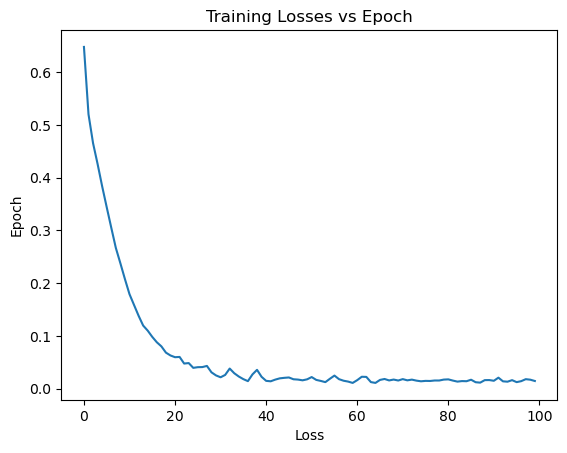

In [13]:
plt.title("Training Losses vs Epoch")
plt.plot(train_losses)
plt.ylabel("Epoch")
plt.xlabel("Loss")
plt.show()

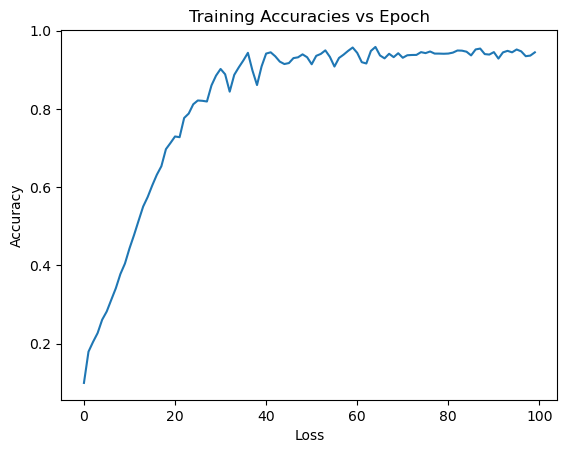

In [14]:
new_train_accs = []
for train_acc in train_accs:
    new_train_accs.append(train_acc.item())

plt.title("Training Accuracies vs Epoch")
plt.plot(new_train_accs)
plt.ylabel("Accuracy")
plt.xlabel("Loss")
plt.show()

## Save, Test and Load Model

In [15]:
torch.save(model.state_dict(), '../combined_model.pth')

In [16]:
model = CombinedModel(
	choice="regnet_x_1_6gf",
	pretrained=True, 		# if pretrained is False, then freeze should also be False
	freeze=True,
	cnn_n_out=256,
	no_layers=2,
	vocab_size=len(vocab), 	# already added by 1
	embedding_dim=64,
	lstm_hidden_dim=256,
	lstm_n_out=128,
)
model.load_state_dict(torch.load('../combined_model.pth'))

<All keys matched successfully>

In [17]:
# create a file for test submission
f = open('../submission_combined.csv', "w")
f.write("ImageID,Labels\n")

# utilise GPU
if torch.cuda.is_available():
	print('using GPU')
	model = model.to('cuda')

# initialize the hidden state
hidden = model.lstm_model.init_hidden(batch_size=BATCH_SIZE)

# idx = 0
model.eval()
for (image_names, images, captions) in test_dataloader:

	# creating new variables for the hidden state, otherwise
	# we'd backprop through the entire training history
	hidden = tuple([each.data for each in hidden])
	
	if torch.cuda.is_available():
		images = images.to('cuda')
		captions = captions.to('cuda')
	
	outputs, _ = model(images, captions, hidden)
	predicted = (F.sigmoid(outputs) > THRESHOLD).int()

	# NOTE: add 1 to the output of predicted!
	# write the output
	for i, predicted_label in enumerate(predicted):
		label = (predicted_label == torch.max(predicted_label)).nonzero().flatten()
		label += 1
		label = label.tolist()
		label = " ".join(str(x) for x in label)

		f.write(image_names[i].split("/")[-1] + "," + str(label) +"\n")

f.close()

using GPU
